Numerical Integration for $\pi$
===

By Jonah Miller  (jonah.maxwell.miller@gmail.com)

Recently I saw [a calculation](https://www.reddit.com/r/dataisbeautiful/comments/8kh2w4/monte_carlo_simulation_of_pi_oc/) of $\pi$ via Monte Carlo methods on [DataIsBeautiful](https://www.reddit.com/r/dataisbeautiful/) on Reddit. [Many people asked if you can do better by choosing an evenly spaced set of points](https://www.reddit.com/r/dataisbeautiful/comments/8kh2w4/monte_carlo_simulation_of_pi_oc/dz7y032) rather than random ones. The answer is yes! But it's more complicated than you might think. Here I thought I'd explore that.

Take a look at the animation linked above first. Or checkout my article on the same process [here](http://www.thephysicsmill.com/2014/05/03/throwing-darts-pi/) That explains how Monte Carlo works for calculating $\pi$ and I assume you know how that works.

As we go, I'll show you the code I use to perform the calculation. Let's do it.

In [1]:
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import scipy as sp
from scipy import optimize

In [2]:
mpl.rcParams.update({'font.size':18})

## Calculating $\pi$ by finding the area of a circle by integration.

The classic calculation of $\pi$ relies on the fact that the area of a circle of radius 1 is $\pi$. It also uses the fact that the area of a square with sides of length 2 is 4. The method essentially compares the area of the circle to the area of the square. The ratio of these areas is $\pi/4$.

The question, then, is how do we calculate the area of the circle? Well, in the Monte Carlo algorithm, we simply randomly throw points into a square and count how many fall a circle contained within it. The ratio of the areas is then the ratio of the points in the circle vs. the square. This algorithm looks something like this:

In [3]:
def monte_carlo_circle(N):
    """Compute pi by using Monte Carlo methods 
    to integrate the area of a unit circle
    and compare it to the area of a  square.
    """
    from numpy.random import uniform
    x = uniform(-1.,1.,N)
    y = uniform(-1.,1.,N)
    rsqr = x*x + y*y
    in_circle = np.logical_or(rsqr < 1, rsqr == 1)
    area_circle = np.sum(in_circle)
    area_square = N
    pi_over_4 = float(area_circle)/float(area_square)
    pi_est = 4.0*pi_over_4
    return pi_est

We can play the same trick, but use a regular grid of points to grid the square and then ask how many of them fall within the circle. The ratio of points in the circle to total points gives the ratio of areas. I call this the *rectangle rule.*

In [4]:
def rectangle_rule_circle(N):
    """Compute pi by using the rectangle rule
    to integrate  the area of a unit circle and
    compare it to the area of a square.
    """
    N_per_axis = int(np.sqrt(float(N)))
    x = np.linspace(-1,1,N_per_axis)
    y = np.linspace(-1,1,N_per_axis)
    hx = x[1]-x[0]
    hy = y[1]-y[0]
    dA = hx*hy
    X,Y = np.meshgrid(x,y, indexing='ij')
    rsqr = X*X + Y*Y
    in_circle = np.logical_or(rsqr <1, rsqr == 1)
    area_circle = dA*np.sum(in_circle)
    pi_est = area_circle
    return pi_est

Another way to look at this is that we are numerically computing an approximation of the integral

$$\pi = \int_{-1}^1\int_{-1}^1 \chi(x,y) dxdy$$

where

$$\chi(x,y) = \begin{cases} 1&\text{if  }x^2 + y^2 \leq 1\\0&\text{otherwise}\end{cases}$$

in this picture, we are asking for the *volume* of a cylinder of height 1 and radius 1. This is an equivalent statement, computationally.  We can take advantage  of this fact to develop a more advanced method. We can use the [definition of an integral given by Liebnitz and Newton](https://en.wikipedia.org/wiki/Integral) to calculate the area under a curve (or volume under a surface). If we use the definition but don't take the limit, we arrive at apprixmate integration rules like the [trapezoid rule](https://en.wikipedia.org/wiki/Trapezoidal_rule). This essentially pretends any curve is a collection of lines and finds the area of the trapezoids defined by those lines. Here's trapezoid rule code  to integrate our circle:

In [5]:
def trapezoid_rule_circle(N):
    """Compute pi by using the trapezoid rule
    to integrate  the area of a unit circle and
    compare it to the area of a square.
    """
    N_per_axis = int(np.sqrt(float(N)))
    x = np.linspace(-1,1,N_per_axis)
    y = np.linspace(-1,1,N_per_axis)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    X,Y = np.meshgrid(x,y, indexing='ij')
    rsqr = X*X + Y*Y
    in_circle = np.logical_or(rsqr <1, rsqr == 1)
    s1 = in_circle[0,0] + in_circle[-1,0] + in_circle[0,-1] + in_circle[-1,-1]
    s2 = (np.sum(in_circle[1:-1,0])
          +np.sum(in_circle[1:-1,-1])
          +np.sum(in_circle[0,1:-1])
          +np.sum(in_circle[-1,1:-1]))
    s3 = np.sum(in_circle[1:-1,1:-1])
    pi_est = 0.25*dx*dy*(s1+2*s2+4*s3)
    return pi_est

### Errors

How do these various approaches compare? Let's find out! Let's calculate the average error as a function of the number of points for each of the three methods:

In [6]:
sizes = np.arange(2**2,2**14)
errors_mc = np.empty(len(sizes),dtype=float)
errors_rect = np.empty(len(sizes),dtype=float)
errors_trapz = np.empty(len(sizes),dtype=float)
for i,s in enumerate(sizes):
    #print("s = {}/{}".format(s,sizes[-1]))
    pi = monte_carlo_circle(s)
    errors_mc[i] = np.abs(pi - np.pi)+1e-15
    pi = rectangle_rule_circle(s)
    errors_rect[i] = np.abs(pi - np.pi)+1e-15
    pi = trapezoid_rule_circle(s)
    errors_trapz[i] = np.abs(pi-np.pi)+1e-15

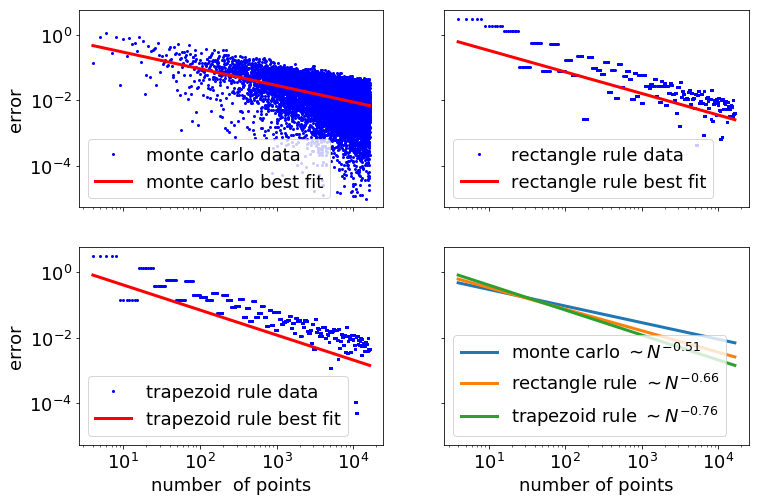

In [7]:
fig,axarr = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,8))
logsizes = np.log10(sizes)
logerrors_mc = np.log10(errors_mc)
logerrors_rect  = np.log10(errors_rect)
logerrors_trapz = np.log10(errors_trapz)
logdecay = lambda x,p,b: p*x + b
decay = lambda x,p,b: np.exp(b)*(x**p)
popt_mc,_ = optimize.curve_fit(logdecay,logsizes,logerrors_mc)
popt_rect,_ = optimize.curve_fit(logdecay,logsizes,logerrors_rect)
popt_trapz,_ = optimize.curve_fit(logdecay,logsizes,logerrors_trapz)

axarr[0,0].loglog(sizes,errors_mc,'bo',ms=2,label='monte carlo data')
axarr[0,0].loglog(sizes,decay(sizes,*popt_mc),'r-',lw=3,label='monte carlo best fit')
axarr[0,0].set_ylabel('error')
axarr[0,0].legend(loc='lower left')
axarr[0,1].loglog(sizes,errors_rect,'bo',ms=2,label='rectangle rule data')
axarr[0,1].loglog(sizes,decay(sizes,*popt_rect),'r-',lw=3,label='rectangle rule best fit')
axarr[0,1].legend(loc='lower left')
axarr[1,0].loglog(sizes,errors_trapz,'bo',ms=2,label='trapezoid rule data')
axarr[1,0].loglog(sizes,decay(sizes,*popt_trapz),'r-',lw=3,label='trapezoid rule best fit')
axarr[1,0].set_ylabel('error')
axarr[1,0].set_xlabel('number  of points')
axarr[1,0].legend(loc='lower left')
axarr[1,1].loglog(sizes,decay(sizes,*popt_mc),lw=3,label=r'monte carlo $\sim N^{%.02f}$' % popt_mc[0])
axarr[1,1].loglog(sizes,decay(sizes,*popt_rect),lw=3,label=r'rectangle rule $\sim N^{%.02f}$' % popt_rect[0])
axarr[1,1].loglog(sizes,decay(sizes,*popt_trapz),lw=3,label=r'trapezoid rule $\sim N^{%.02f}$' % popt_trapz[0])
axarr[1,1].legend(loc='lower left')
axarr[1,1].set_xlabel('number of points')
plt.legend()
plt.savefig('figures/pi_from_area_of_a_circle.png',bbox_inches='tight')

Monte Carlo integration is random so it's by far the most noisy. It's at the top left. The rectangle rule is on the top right and the trapezoidal rule at the bottom left. The dots are data and the solid lines are best fits to 
$$\epsilon = \frac{A}{N^p}$$
where $\epsilon$ is the error, $N$ is the number of points, and $p$  is some decay rate. On the bottom left, I compare these decay rates.

Although Monte Carlo *can* randomly do very well, *on average*, the trapezoidal rule does a bit better.

## Doing *much* better than Monte Carlo

So is this the end of the story? Turns out no. We can actually do *much* better than Monte Carlo if we're a bit more clever.

In one sense, integrating the volume of a cylinder is extraordinarily simple... it's just sharp edges, after all. But sharp edges in another real sense are very difficult to handle numerically. A number of extremely accurate numerical methods rely on the function being integrated being "smooth" in a meaningful sense. The selection function $\chi$ was very not smooth. It had a sharp jump from 0 to 1 and back to zero. So let's change the problem. Can we calculate $\pi$ via an integral like this one?

$$\pi = \int_0^1 f(x) dx$$

for some function $f(x)$?

Yes! This integral will do:

$$\pi = \int_0^1 \frac{4}{1+x^2}dx$$

You'll have to  trust me that this is true, but it is... and we'll see that numerically. Here's what the curve looks like:

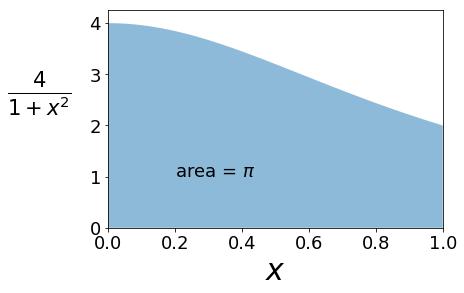

In [8]:
def curve(x):
    "The integral of this curve from 0 to 1 is pi"
    return 4.0/(1+x*x)

x = np.linspace(0,1,100)
y = curve(x)
plt.fill_between(x,y,alpha=0.5)
plt.text(0.2,1,r'area = $\pi$')
plt.xlim(0,1)
plt.ylim(0,4.25)
plt.xlabel(r'$x$',fontsize=30)
plt.ylabel(r'$\frac{4}{1+x^2}$',fontsize=30,rotation=0,labelpad=50)
plt.savefig('figures/area-to-integrate.png',bbox_inches='tight')

As you can see, the area under the curve is the integral, and  it equals $\pi$. 

So we can calculate the area by using Monte Carlo methods essentially the same way we did before. We randomly choose a point in the rectangle with one side of length 1 and one side of length 4. And then we ask if it falls below the curve. If it does, we count it. Then the total number  of points under the curved divided by the total number of points in the square should be  $\pi/4$.

In [9]:
def monte_carlo_curve(N):
    """Compute pi by using Monte Carlo methods 
    to integrate the area under curve
    and compare it to the area of a  square.
    """
    from numpy.random import uniform
    x = uniform(0.,1.,N)
    y = uniform(0.,4.,N)
    under_curve = np.logical_or(y < curve(x), y == curve(x))
    area_under_curve = np.sum(under_curve)
    area_square = N
    pi_over_4 = float(area_under_curve)/float(area_square)
    pi_est = 4.0*pi_over_4
    return pi_est

To compute the integral under the curve via the trapezoidal rule, we'll do things slightly differently, though. We take $N$ points along the line segment $[0,1]$. Then we calculate trapezoids based on the height of the curve at each point, take the area of the trapezoids, and we have our integral. That's what's going on in this lettle segment of code:

In [10]:
def trapz_curve(N):
    """Compute pi by using the trapezoid rule
    to integrate  the area under the curve
    """
    x = np.linspace(0,1,N)
    dx = x[1]-x[0]
    y = curve(x)
    integrand = 0.5*(y[1:]+y[:-1])*dx
    integral = np.sum(integrand)
    pi_est = integral
    return pi_est

Finally, we can do **way** better  by using a different trick, known as [Gauss quadrature.](https://en.wikipedia.org/wiki/Gaussian_quadrature) The idea here is that we approximate our curve as a polynomial of the form
$$f(x) \approx \sum_{i=0}^N a_i x^i$$
where $a_i$ are some numbers to be determined. This integral is known analytically as:
$$\int_0^1 f(x) dx \approx \sum_{i=0}^{N} \frac{a_i}{i+1}$$
so all have to do to perform the integration is compute those coefficients $a_i$. (I'm glossing over many details here.)

These coefficients  can be  computed quite easily by evaluating the function at a set of specially chosen points which are not uniform but certainly not random and then multiplying the function by an appropriate "weight." I use points and weights corresponding to [Gauss-Legendre-Lobatto quadrature.](http://www.dam.brown.edu/people/alcyew/handouts/GLquad.pdf)

In [11]:
def gauss_lobatto_curve(N):
    """Compute pi by using Gauss-Legendre
    quadrature to integrate 
    the area under the curve
    """
    from numpy.polynomial.legendre import Legendre
    POLY=Legendre
    order = N-1
    xref = np.sort(np.concatenate((np.array([-1,1]),
                                   POLY.basis(order).deriv().roots())))
    x = (xref + 1.0)/2.0
    interior_weights = 2/((order+1)*order*POLY.basis(order)(xref[1:-1])**2)
    boundary_weights = np.array([1-0.5*np.sum(interior_weights)])
    weights_ref = np.concatenate((boundary_weights,
                                  interior_weights,
                                  boundary_weights))
    weights = 0.5*weights_ref
    
    y = curve(x)
    integrand = y*weights
    integral = np.sum(integrand)
    pi_est  = integral
    
    return pi_est

So how do these methods compare?

In [12]:
sizes = np.arange(2**2,2**6)
errors_mc = np.empty(len(sizes),dtype=float)
errors_trapz = np.empty(len(sizes),dtype=float)
errors_gauss = np.empty(len(sizes),dtype=float)
for i,s in enumerate(sizes):
    pi = monte_carlo_curve(s)
    errors_mc[i] = np.abs(pi - np.pi)+1e-15
    pi = trapz_curve(s)
    errors_trapz[i] = np.abs(pi - np.pi)+1e-15
    pi = gauss_lobatto_curve(s)
    errors_gauss[i] = np.abs(pi-np.pi)+1e-15

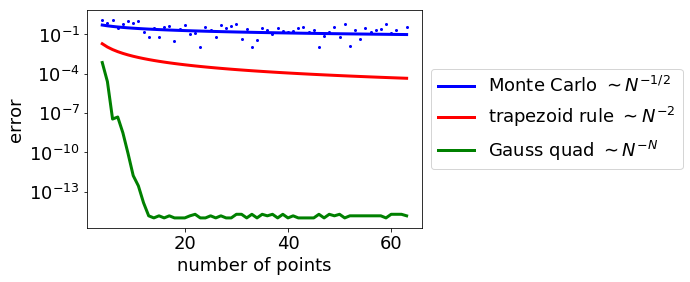

In [13]:
logsizes = np.log10(sizes)
logerrors_mc = np.log10(errors_mc)
logerrors_trapz  = np.log10(errors_trapz)
logerrors_gauss = np.log10(errors_gauss)
logdecay = lambda x,p,b: p*x + b
decay = lambda x,p,b: np.exp(b)*(x**p)
popt_mc,_ = optimize.curve_fit(logdecay,logsizes,logerrors_mc)
popt_trapz,_ = optimize.curve_fit(logdecay,logsizes,logerrors_trapz)
popt_gauss,_ = optimize.curve_fit(logdecay,logsizes,logerrors_gauss)

plt.semilogy(sizes,errors_mc,'bo',ms=2)#,label='Monte Carlo data')
plt.semilogy(sizes,decay(sizes,*popt_mc),'b-',lw=3,label=r'Monte Carlo $\sim N^{-1/2}$')
plt.semilogy(sizes,errors_trapz,'r-',lw=3,label=r'trapezoid rule $\sim N^{-2}$')
plt.semilogy(sizes,errors_gauss,'g-',lw=3,label=r'Gauss quad $\sim N^{-N}$')
plt.xlabel('number of points')
plt.ylabel('error')
#plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('figures/pi_from_curve.png',bbox_inches='tight')

Monte Carlo is least accurate---the error decays only as $1/\sqrt{N}$, where $N$ is the number of points used. The trapezoid rule decause as  $1/N^2$ and does much better than Monte Carlo. But nothing can beat Gauss quadrature, which has an error that decays exponentially  until it hits the maximum precision afforded by floating point arithmetic, at which point it levels off.

## To summarize:

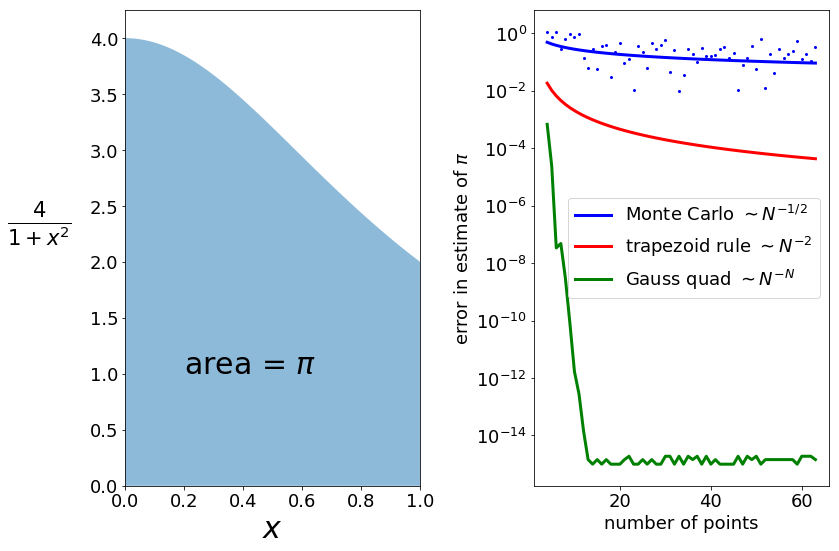

In [14]:
x = np.linspace(0,1,100)
y = curve(x)

logsizes = np.log10(sizes)
logerrors_mc = np.log10(errors_mc)
logerrors_trapz  = np.log10(errors_trapz)
logerrors_gauss = np.log10(errors_gauss)
logdecay = lambda x,p,b: p*x + b
decay = lambda x,p,b: np.exp(b)*(x**p)
popt_mc,_ = optimize.curve_fit(logdecay,logsizes,logerrors_mc)
popt_trapz,_ = optimize.curve_fit(logdecay,logsizes,logerrors_trapz)
popt_gauss,_ = optimize.curve_fit(logdecay,logsizes,logerrors_gauss)

fig,axarr=plt.subplots(1,2,figsize=(12,8))

axarr[0].fill_between(x,y,alpha=0.5)
axarr[0].text(0.2,1,r'area = $\pi$',fontsize=30)
axarr[0].set_xlim(0,1)
axarr[0].set_ylim(0,4.25)
axarr[0].set_xlabel(r'$x$',fontsize=30)
axarr[0].set_ylabel(r'$\frac{4}{1+x^2}$',fontsize=30,rotation=0,labelpad=50)

axarr[1].semilogy(sizes,errors_mc,'bo',ms=2)#,label='Monte Carlo data')
axarr[1].semilogy(sizes,decay(sizes,*popt_mc),'b-',lw=3,label=r'Monte Carlo $\sim N^{-1/2}$')
axarr[1].semilogy(sizes,errors_trapz,'r-',lw=3,label=r'trapezoid rule $\sim N^{-2}$')
axarr[1].semilogy(sizes,errors_gauss,'g-',lw=3,label=r'Gauss quad $\sim N^{-N}$')
axarr[1].set_xlabel('number of points')
axarr[1].set_ylabel(r'error in estimate of $\pi$')
axarr[1].legend()
plt.tight_layout()
plt.savefig('figures/summary_plot.png',bbox_inches='tight')